In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import ResNet50_Weights

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import math
import copy

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [60]:
# Data transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [61]:
# Load datasets
train_dataset = datasets.ImageFolder(
    root='/kaggle/input/sapienza-fire/dl2425_challenge_dataset/train', 
    transform=train_transforms
)
val_dataset = datasets.ImageFolder(
    root='/kaggle/input/sapienza-fire/dl2425_challenge_dataset/val', 
    transform=val_transforms
)

In [62]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [63]:
# Initialize ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features

# Replace the classifier with a custom head for binary classification
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.SiLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.SiLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 1)
)

# Move the model to the GPU/CPU
model = model.to(device)

In [64]:
from collections import Counter

# Assuming train_dataset has a targets attribute or a list of labels
labels = train_dataset.targets  # Replace with your dataset's label access method
class_counts = Counter(labels)

# Get total samples and counts for each class
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

print(f"Class Weights: {class_weights}")

Class Weights: {0: 1.5999414262703178, 1: 2.6668293873566022}


In [65]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
 
    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)  
        alpha_t = self.alpha[targets.long()] 
        focal_loss = alpha_t * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean()

alpha = torch.tensor([class_weights[0], class_weights[1]]).to(device)
criterion = FocalLoss(alpha=alpha, gamma=2)

# Define the optimizer with separate parameter groups
optimizer = optim.Adam([
    {"params": [p for n, p in model.named_parameters() if "fc" not in n], "lr": 1e-5, "weight_decay": 1e-5},  # ResNet backbone
    {"params": model.fc.parameters(), "lr": 1e-4, "weight_decay": 1e-5}  # Classifier head
])

# Define the learning rate scheduler
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
#max_lr = 1e-4  # Maximum learning rate
epochs = 30
#steps_per_epoch = len(train_loader)
#total_steps = epochs * steps_per_epoch
from torch.optim.lr_scheduler import OneCycleLR

#scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


In [66]:
class EarlyStopping:
    def __init__(self, patience=15, delta=0, path="best_model.pth", verbose=True):
        """
        Args:
            patience (int): How many epochs to wait after last improvement in validation loss.
            delta (float): Minimum change in validation loss to qualify as an improvement.
            path (str): Path to save the best model.
            verbose (bool): Whether to print status updates.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            # Save the best model
            torch.save(model.state_dict(), self.path)
            if self.verbose:
                print(f"Validation loss improved. Saving model to {self.path}.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"Validation loss did not improve for {self.counter} epoch(s).")
            if self.counter >= self.patience:
                self.early_stop = True

In [67]:
# Initialize lists to store losses
training_losses = []
validation_losses = []

num_epochs = 30
best_val_loss = float('inf')
best_val_accuracy = 0.0

early_stopping = EarlyStopping(path="best_model.pth")


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    training_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

    # Validation step
    model.eval()
    val_running_loss = 0.0
    correct_predictions = 0

    # Initialize lists to store predictions and labels
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.float().unsqueeze(1).to(device)

            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item() * val_images.size(0)

            # Calculate accuracy
            preds = torch.sigmoid(val_outputs) >= 0.5
            correct_predictions += torch.sum(preds == val_labels.byte())

            # Collect predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())

    val_epoch_loss = val_running_loss / len(val_dataset)
    validation_losses.append(val_epoch_loss)
    val_accuracy = correct_predictions.double() / len(val_dataset)

    # Step the scheduler based on validation loss
    #scheduler.step(val_epoch_loss)
    scheduler.step()
    
    # Print the current learning rate
    current_lr = scheduler.get_last_lr()[0]
    print(f'Current Learning Rate: {current_lr}')

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        best_val_accuracy = val_accuracy.item()
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved Best Model at Epoch {epoch+1}")

    # Early stopping check
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break
        
    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch 1/30, Training Loss: 0.1542
Current Learning Rate: 9.938441702975689e-06
Saved Best Model at Epoch 1
Validation loss improved. Saving model to best_model.pth.
Validation Loss: 0.0672, Validation Accuracy: 0.9670
Epoch 2/30, Training Loss: 0.1060
Current Learning Rate: 9.755282581475769e-06
Saved Best Model at Epoch 2
Validation loss improved. Saving model to best_model.pth.
Validation Loss: 0.0482, Validation Accuracy: 0.9766
Epoch 3/30, Training Loss: 0.0954
Current Learning Rate: 9.45503262094184e-06
Saved Best Model at Epoch 3
Validation loss did not improve for 1 epoch(s).
Validation Loss: 0.0463, Validation Accuracy: 0.9785
Epoch 4/30, Training Loss: 0.0847
Current Learning Rate: 9.045084971874738e-06
Saved Best Model at Epoch 4
Validation loss improved. Saving model to best_model.pth.
Validation Loss: 0.0448, Validation Accuracy: 0.9798
Epoch 5/30, Training Loss: 0.0766
Current Learning Rate: 8.535533905932739e-06
Saved Best Model at Epoch 5
Validation loss improved. Saving

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee63ade5090>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 12/30, Training Loss: 0.0574
Current Learning Rate: 3.454915028125264e-06
Validation loss did not improve for 3 epoch(s).
Validation Loss: 0.0484, Validation Accuracy: 0.9773
Epoch 13/30, Training Loss: 0.0575
Current Learning Rate: 2.7300475013022666e-06
Validation loss did not improve for 4 epoch(s).
Validation Loss: 0.0389, Validation Accuracy: 0.9827
Epoch 14/30, Training Loss: 0.0549
Current Learning Rate: 2.061073738537635e-06
Validation loss did not improve for 5 epoch(s).
Validation Loss: 0.0390, Validation Accuracy: 0.9827
Epoch 15/30, Training Loss: 0.0520
Current Learning Rate: 1.4644660940672626e-06
Validation loss did not improve for 6 epoch(s).
Validation Loss: 0.0431, Validation Accuracy: 0.9814
Epoch 16/30, Training Loss: 0.0516
Current Learning Rate: 9.549150281252633e-07
Validation loss did not improve for 7 epoch(s).
Validation Loss: 0.0402, Validation Accuracy: 0.9827
Epoch 17/30, Training Loss: 0.0544
Current Learning Rate: 5.449673790581611e-07
Validation lo

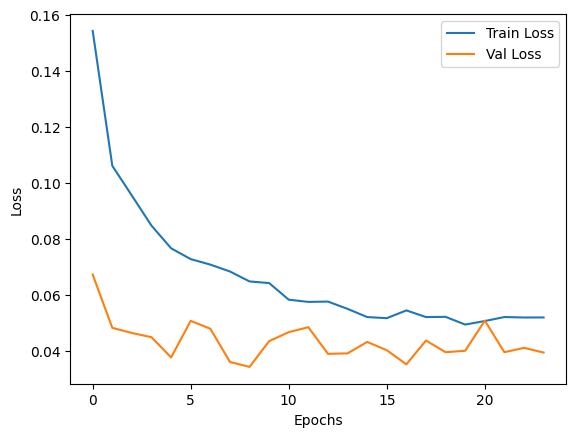

In [68]:
plt.plot(training_losses, label="Train Loss")
plt.plot(validation_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

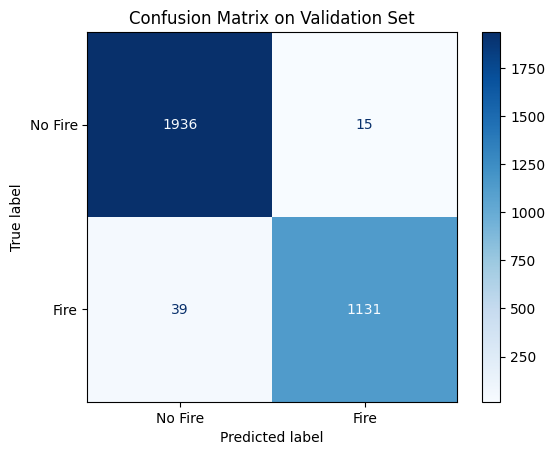

In [69]:
# Generate confusion matrix
# Convert lists to numpy arrays and flatten
all_preds_np = np.array(all_preds).astype(int).flatten()
all_labels_np = np.array(all_labels).astype(int).flatten()

# Compute confusion matrix
cm = confusion_matrix(all_labels_np, all_preds_np)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Fire', 'Fire'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Validation Set')
plt.show()

In [70]:
# Load the trained model from a file
def load_model(model_path, device):
    # Reinitialize the model architecture (same as during training)
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    num_features = model.fc.in_features

    # Replace the classifier with the custom head
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.SiLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 256),
        nn.SiLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 1)
    )

    # Move the model to the appropriate device
    model = model.to(device)

    # Load the saved state dictionary
    model.load_state_dict(torch.load(model_path, map_location=device))

    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded from {model_path}")
    return model

# Path to the saved model
model_path = "best_model.pth"

# Load the model
model = load_model(model_path, device)

Model loaded from best_model.pth


/tmp/ipykernel_23/3918307378.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [71]:
from torch.utils.data import Dataset
from PIL import Image

class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        """
        Custom Dataset for test data without class labels.
        Args:
            test_dir (str): Path to the directory containing test images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.test_dir = test_dir
        self.transform = transform
        self.image_paths = sorted([os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure 3 channels (RGB)
        
        if self.transform:
            image = self.transform(image)
        
        # Return the image and its filename
        return image, os.path.basename(img_path)

# Define the test dataset and DataLoader
test_dir = '/kaggle/input/sapienza-fire/dl2425_challenge_dataset/test'  # Update to your test folder path
test_dataset = TestDataset(test_dir, transform=val_transforms)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [72]:
def save_test_predictions_to_csv_custom(model, dataloader, output_csv_path):
    model.eval()  # Set model to evaluation mode
    results = []  # List to store the results

    with torch.no_grad():
        for images, file_names in dataloader:
            images = images.to(device)

            # Perform forward pass
            outputs = model(images)
            preds = torch.sigmoid(outputs) >= 0.5  # Apply sigmoid and threshold at 0.5

            # Add predictions to the results list
            for file_name, pred in zip(file_names, preds.cpu().numpy().flatten().astype(int)):
                results.append({"id": file_name, "class": pred})

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Save DataFrame to CSV
    results_df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")

# Specify the output CSV path
output_csv_path = "test_predictions.csv"

# Call the function with the model and test DataLoader
save_test_predictions_to_csv_custom(model, test_loader, output_csv_path)

Predictions saved to test_predictions.csv
